# LLM-as-a-judge

## Variable Definitions

In [1]:
import pandas as pd
import os
from tqdm import tqdm
tqdm.pandas()

from src.generate import load_llama, simple_call_llama
from src.data import files_to_df, read_document


N_EXPECTED_SAMPLES = 35

model_id = "/gpfs/projects/bsc14/abecerr1/hub/models--meta-llama--Llama-3.2-3B-Instruct/snapshots/0cb88a4f764b7a12671c53f0838cd831a0843b95"
source_path = "output/samples/en/phase_2/"
prompts_path = "utils/prompts"

path_gen = os.path.join(source_path, "generated")
path_orig = os.path.join(source_path, "original")
path_human = os.path.join(source_path, "human_eval.csv")
path_auto = os.path.join(source_path, "auto_eval.csv")

path_guidelines = os.path.join(prompts_path, "guidelines.txt")
guidelines = open(path_guidelines, "r").read()

assert os.path.exists(path_gen), f"Path {path_gen} does not exist"
assert os.path.exists(path_orig), f"Path {path_orig} does not exist"
assert os.path.exists(path_human), f"Path {path_human} does not exist"
assert os.path.exists(path_auto), f"Path {path_auto} does not exist"
assert os.path.exists(path_guidelines), f"Path {path_guidelines} does not exist"

## Load Data

### Clinical cases and Discharge summaries

In [2]:
## Load and preprocess generated samples
df_pairs_gen = files_to_df(path_gen)
df_pairs_gen["filenameid"] = df_pairs_gen["filenameid"].str.replace("_transformed_step1", "")

## Load and preprocess original samples
df_pairs_orig = files_to_df(path_orig)

df_pairs = df_pairs_orig.merge(df_pairs_gen, on="filenameid", suffixes=("_orig", "_gen"))

assert len(df_pairs) == N_EXPECTED_SAMPLES, f"Expected {N_EXPECTED_SAMPLES} samples, got {len(df_pairs)}"

df_pairs = df_pairs.rename(columns={"text_orig": "clinical_case", "text_gen": "discharge_summary"})
df_pairs.head()

,filenameid,clinical_case,discharge_summary
0,32153696,An 80-year-old man who worked as a constructio...,**Discharge Summary**\n\n**Patient Information...
1,32470561,A 46-years-old female was admitted to our depa...,**Discharge Summary**\n\n**Patient Information...
2,29617510,An 81-year-old male patient was admitted due t...,**Discharge Summary**\n\n**Patient Information...
3,38422307,A 43-year-old female patient with uterine diff...,**Discharge Summary**\n\n**Patient Information...
4,31204375,A 92-year-old man was admitted to our hospital...,**Discharge Summary**\n\n**Patient Information...


### Human Evaluation

In [3]:
df_human = pd.read_csv(path_human)

d_score_cols = {
                        "Overall validation [Content Relevance]": "Content Relevance",
                        "Overall validation [Information Completeness]": "Information Completeness",
                        "Overall validation [Clarity and Structure]": "Clarity and Structure",
                        "Overall validation [Content Accuracy]": "Content Accuracy",
                        "Overall validation [Hallucinations]": "Hallucinations",
                        "Overall validation [Impact of Hallucinations]": "Impact of Hallucinations",
                        "Overall validation [Relevance to Practice]": "Relevance to Practice",
                        "Overall validation [Overall Quality]": "Overall Quality",
                        "Positive highlights: Describe what aspects of the synthetic discharge summaries resemble the best real EHRs? (Empty if nothing remarkable)": "Positive highlights",
                        "Negative highlights: Which aspects of the synthetic discharge summaries do not resemble well real EHRs? (Empty if nothing remarkable)": "Negative highlights",
                        "Other Comments: Do you have any other feedback or comment on the generated synthetic discharge summaries or in the original cases? (Empty if nothing remarkable)": "Other Comments"
}

df_human.rename(columns=d_score_cols, inplace=True)
df_human.rename(columns={"Original file name (e.g. 36951253)": "filenameid"}, inplace=True)

columns_to_exclude = [
    "Email Address", "Timestamp"
]
df_human = df_human.drop(columns=columns_to_exclude)
df_human = df_human.fillna("")

df_human_prompt = df_human[["filenameid"]].copy()
df_human_prompt["human_score"] = ""
df_human_prompt.loc[:, "human_score"] = df_human.iloc[:, 1:].apply(lambda x: x.to_dict(), axis=1)

df_human_prompt.head()

,filenameid,human_score
0,33857916,"{'Content Relevance': 1, 'Information Complete..."
1,34530632,"{'Content Relevance': 5, 'Information Complete..."
2,32997782,"{'Content Relevance': 4, 'Information Complete..."
3,31378248,"{'Content Relevance': 5, 'Information Complete..."
4,30785587,"{'Content Relevance': 1, 'Information Complete..."


### Automatic Evaluation

In [4]:
df_auto = pd.read_csv(path_auto).drop(columns=["cluster"])
df_auto.rename(columns={"filename": "filenameid"}, inplace=True)

df_auto_prompt = df_auto[["filenameid"]].copy()
df_auto_prompt["auto_score"] = ""
df_auto_prompt.loc[:, "auto_score"] = df_auto.iloc[:, 1:].apply(lambda x: x.to_dict(), axis=1)

df_auto_prompt.head()

,filenameid,auto_score
0,32153696,"{'precision': 0.8181817438016598, 'recall': 0...."
1,32111713,"{'precision': 0.8235293875432533, 'recall': 0...."
2,31912911_1,"{'precision': 0.4999999642857168, 'recall': 0...."
3,34962277,"{'precision': 0.9999999285714336, 'recall': 0...."
4,34118375,"{'precision': 0.9499999525000024, 'recall': 0...."


### Combination

In [5]:
# model = load_llama(model_id)
df_human_prompt["filenameid"] = df_human["filenameid"].astype(str)
df_auto_prompt["filenameid"] = df_auto["filenameid"].astype(str)
df_pairs["filenameid"] = df_pairs["filenameid"].astype(str)

df_prompt = df_pairs.merge(df_human_prompt, on="filenameid").merge(df_auto_prompt, on="filenameid", how="inner")
df_prompt.head()

,filenameid,clinical_case,discharge_summary,human_score,auto_score
0,29617510,An 81-year-old male patient was admitted due t...,**Discharge Summary**\n\n**Patient Information...,"{'Content Relevance': 4, 'Information Complete...","{'precision': 0.8666666088888928, 'recall': 0...."
1,31204375,A 92-year-old man was admitted to our hospital...,**Discharge Summary**\n\n**Patient Information...,"{'Content Relevance': 4, 'Information Complete...","{'precision': 0.3333333055555579, 'recall': 0...."
2,31056078,"Initial presentation\nA 55-year-old, Caucasian...",**Discharge Summary**\n\n**Patient Information...,"{'Content Relevance': 5, 'Information Complete...","{'precision': 0.9189188940832732, 'recall': 0...."
3,31486515,A 57-year-old Caucasian man was admitted to th...,**Discharge Summary**\n\n**Patient Information...,"{'Content Relevance': 5, 'Information Complete...","{'precision': 0.8275861783590973, 'recall': 0...."
4,31512669,A 25-year-old male who presented with acute on...,**Discharge Summary**\n\n**Patient Information...,"{'Content Relevance': 5, 'Information Complete...","{'precision': 0.8888888559670793, 'recall': 0...."


# Template Preparation

### Load Templates

In [6]:
template = open("utils/templates/basic/template.txt", "r").read()
example_template = open("utils/templates/basic/example_template.txt", "r").read()
system_prompt = open("utils/templates/basic/system.txt", "r").read()

### Example on how to use the templates

In [7]:
from src.data import Prompt, create_examples

# Usage Example

# example_filenames = ["29617510", "31204375"]
example_filenames = df_prompt.sample(5)["filenameid"].tolist()
df_examples = df_prompt[df_prompt["filenameid"].isin(example_filenames)] # [dict_keys(['filenameid', 'clinical_case', 'discharge_summary', 'human_score', 'auto_score'])]
few_shot_examples = df_examples.to_dict(orient="records") # [{'filenameid': '29617510', 'clinical_case': "An 81-year-old male patient...", "discharge_summary": "Patient was admitted to the hospital..."}]


examples = create_examples(few_shot_examples, example_template=example_template)

# for i, row in df_pairs.head(1).iterrows():

row = df_prompt.sample(1).iloc[0]

prompt = Prompt(
    template=template,
    guidelines=guidelines,
    clinical_case=row["clinical_case"],
    discharge_summary=row["discharge_summary"],
    examples=str(examples),  # Add few-shot examples
)

print(prompt)


Look at these guidelines carefully, i have also provided the dataset for you to analyze:
    
Guidelines : One of the main bottlenecks for the development of clinical NLP resources if the lack of access to clinical records due to data privacy issues. This is particularly true for developments beyond English, as most of the accessible anonymized clinical record datasets are only available for this language.

To examine if clinical case report publications could potentially be considered as a data source to generate synthetic clinical discharge summaries by means of generative AI solutions, prompt instructions combined with automatic clinical were applied.

This structured summary has the purpose to systematically characterize the clinical language characteristics of synthetic discharge summaries.

Each discharge summary was assessed for a predefined set of features.

Likert scale features (to extract statistics) from 1 to 5:

- Content Relevance: Does the summary focus on clinically rel

### Load Model and Generate Prompts

In [8]:
from src.generative_models import LlamaInstruct
model = LlamaInstruct(model_id)
df_prompt["prompts"] = df_prompt.progress_apply(lambda x: Prompt(guidelines=guidelines, template=template, clinical_case=x["clinical_case"], discharge_summary=x["discharge_summary"], examples=str(examples)).text, axis=1)
# text_out = model.generate(prompt, system=system_prompt, max_new_tokens=1024, temperature=0.1)
# d_out = json.loads(text_out)
# d_out

/gpfs/projects/bsc14/code/MultiSynDS/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.69it/s]
Device set to use cuda:0


Model /gpfs/projects/bsc14/abecerr1/hub/models--meta-llama--Llama-3.2-3B-Instruct/snapshots/0cb88a4f764b7a12671c53f0838cd831a0843b95 loaded successfully.


100%|██████████| 14/14 [00:00<00:00, 12568.55it/s]


### Generate Predictions JSON

In [9]:
import datasets

ds_prompt = datasets.Dataset.from_pandas(df_prompt)
ds_prompt

Dataset({
    features: ['filenameid', 'clinical_case', 'discharge_summary', 'human_score', 'auto_score', 'prompts'],
    num_rows: 14
})

In [10]:
def create_generated_samples(row):
    row["generated"] = model.generate(row["prompts"], system=system_prompt, max_new_tokens=512, temperature=0.1)
    return row
ds_prompt = ds_prompt.map(create_generated_samples)

Map: 100%|██████████| 14/14 [02:53<00:00, 12.38s/ examples]


In [ ]:
from src.generate import safe_generate
df_prompt["generation"] = df_prompt["prompts"].progress_apply(lambda x: model.generate(x["prompts"], system=system_prompt, max_new_tokens=512, temperature=0.1))

 57%|█████▋    | 8/14 [01:54<01:33, 15.61s/it]

: 

In [14]:
df_example_scores = pd.DataFrame(df_examples["human_score"].tolist())
df_example_scores["filenameid"] = df_examples["filenameid"]
df_example_scores

,Content Relevance,Information Completeness,Clarity and Structure,Content Accuracy,Hallucinations,Impact of Hallucinations,Relevance to Practice,Overall Quality,Positive highlights,Negative highlights,Other Comments,filenameid
0,4,4,4,5,1,1,5,4,,"falta información sobre tipo de prótesis, ause...",,29617510
1,4,3,4,4,1,1,4,4,,Se pierde mucha información sobre la explicaci...,,31204375


In [15]:
df_human_preds = pd.DataFrame(df_prompt["human_score"].tolist())
df_human_preds["filenameid"] = df_prompt["filenameid"]
df_human_preds

,Content Relevance,Information Completeness,Clarity and Structure,Content Accuracy,Hallucinations,Impact of Hallucinations,Relevance to Practice,Overall Quality,Positive highlights,Negative highlights,Other Comments,filenameid
0,4,4,4,5,1,1,5,4,,"falta información sobre tipo de prótesis, ause...",,29617510
1,4,3,4,4,1,1,4,4,,Se pierde mucha información sobre la explicaci...,,31204375
2,5,5,3,5,1,1,3,4,"datos muy completos, estrcutura fiel al docume...",La parte correspondiente a la enfermedad actu...,,31056078
3,5,5,4,4,1,1,4,4,,Se debería mencionar el motivo de admisión: an...,,31486515
4,5,5,4,4,1,1,4,4,Muy bien especificado Chief complaint,Se podría separar la enfermedad actual de los ...,,31512669
5,4,2,5,4,1,1,2,3,Very well structured and explained. Abbrevatio...,"The text has been oversummarized, leaving out ...",,32997782
6,5,5,4,5,1,1,5,5,,la razón de admisión suele ser algo más genera...,,31557359
7,5,4,5,5,1,1,5,5,,,,26989133
8,5,5,5,5,1,1,5,5,,,,31049155
9,5,5,5,5,1,1,5,5,Highly accurate in the diagnosis.An excellent ...,Omited information: ECG Holter and EKG after C...,,31378248


In [16]:
df_preds = pd.DataFrame(df_prompt["generation"].values.tolist())
df_preds["filenameid"] = df_prompt["filenameid"]
df_preds

,Content Relevance,Information Completeness,Clarity and Structure,Content Accuracy,Hallucinations,Impact of Hallucinations,Relevance to Practice,Overall Quality,Positive highlights,Negative highlights,Other comments on Generated/Original data sources,filenameid
0,4,4,4,5,1,1,5,4,,"falta información sobre tipo de prótesis, ause...",,29617510
1,5,4,5,5,1,1,5,5,,,,31204375
2,4,4,4,5,1,1,5,4,,"falta información sobre tipo de prótesis, ause...",,31056078
3,5,5,5,5,2,2,5,5,,"falta información sobre tipo de prótesis, ause...",,31486515
4,5,5,5,5,1,1,5,5,,"falta información sobre tipo de prótesis, ause...",,31512669
5,4,4,4,5,1,1,5,4,,"falta información sobre tipo de prótesis, ause...",,32997782
6,5,5,5,5,1,1,5,5,,,,31557359
7,5,5,5,5,1,1,5,5,,,,26989133
8,5,5,5,5,1,1,5,5,,,,31049155
9,4,4,4,5,1,1,5,4,,"falta información sobre tipo de prótesis, ause...",,31378248


# Analysis

In [24]:
import numpy as np
from scipy.stats import pearsonr
df_hm_llm_corr = df_human_preds.merge(df_preds, on="filenameid", suffixes=("_human", "_llm")).select_dtypes(np.number).corr()
eval_metric = pearsonr(df_human_preds["Overall Quality"], df_preds["Overall Quality"])
eval_metric

PearsonRResult(statistic=0.4583333333333335, pvalue=0.09930462960498529)

<Axes: >

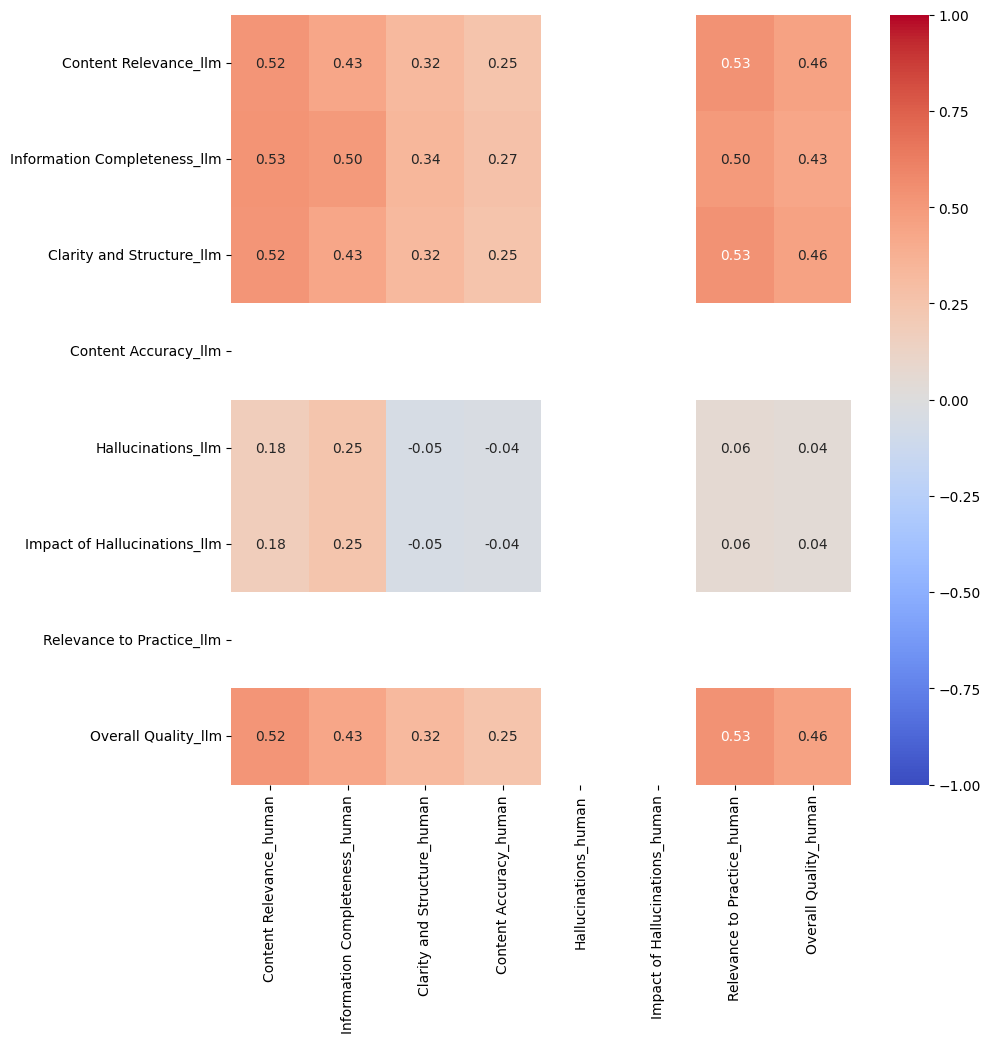

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
sns.heatmap(df_hm_llm_corr.iloc[len(df_hm_llm_corr) // 2:, :len(df_hm_llm_corr) // 2], annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)

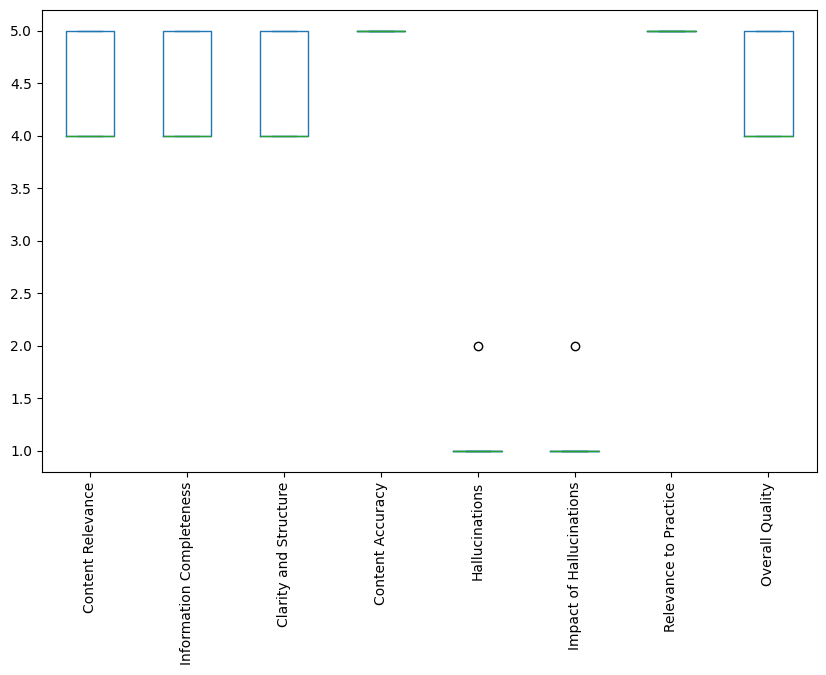

In [ ]:
import matplotlib.pyplot as plt

df_preds.plot(kind="box", y=['Content Relevance',
       'Information Completeness', 'Clarity and Structure', 'Content Accuracy',
       'Hallucinations', 'Impact of Hallucinations', 'Relevance to Practice',
       'Overall Quality'],
               figsize=(10, 6))
plt.xticks(rotation=90);

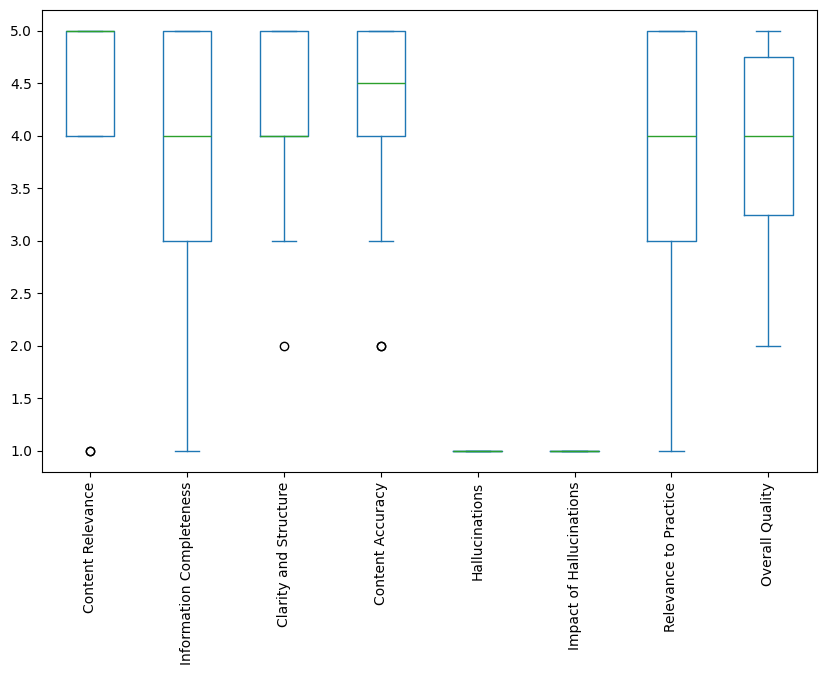

In [ ]:
df_human_preds.plot(kind="box", y=['Content Relevance',
       'Information Completeness', 'Clarity and Structure', 'Content Accuracy',
       'Hallucinations', 'Impact of Hallucinations', 'Relevance to Practice',
       'Overall Quality'],
               figsize=(10, 6))
plt.xticks(rotation=90);